# DK_0911_post_allele_analysis_v02

Based on original code by Benjamin Schwessinger.

- Inputs: output from `DK_0911_defining_alleles_v02` & primary+haplotig (ph) protein/gene/cds .*fasta* files from `DK_0911_generate_fasta_files_from_gff3`.
- Programs: **MUSCLE**, **PAML**
- Purpose: generate and save a DataFrame containing dN/dS information (number of nonsynonymous substitutions per non-synonymous site to the number of synonymous substitutions per synonymous site), as well as Hamming & Levenshtein distances (measures of % identity). Also provides visualisations of some of this data.

#### Overview
1. Reads in the large allele DataFrames generated in `DK_0911_defining_alleles_v02` (i.e. proteinortho hits OR best blast hit) - see description header cell in that notebook for more information on which alleles are included in that DataFrame.
2. Filters the allele DataFrames based on %ID and %QCov (this can be set to filter only BLAST-identified alleles or both BLAST- and proteinortho-identified alleles) so that distance information is not calculated on an unnecessarily large number of alleles.
3. Calculates distance & dN/dS information, and saves this to an output file so that it does not have to be re-calculated (if for whatever reason, the inputs change so that dN/dS or distance information should change, this output file (`DK_0911_v0x_analysed_alleles.df`) should be deleted so that it can be re-generated.
4. Plots graphs of allele-type distribution (pie chart) and allele-type Levenshtein distances (measures of similarity) for different levels of allele-filtering (QCov/TCov/%ID/Levenshtein similarity).

NB:
- dN/dS information is currently not utilised in this script.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import shutil
from Bio import SeqIO
from Bio import AlignIO
import distance
import editdistance
import math
import subprocess
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections

In [3]:
GENOME_VERSION = 'v04'

YN00_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/post_analysis/yn00.ctl'
BASE_OUT_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/post_analysis/%s' % (GENOME_VERSION)
ALLELE_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/defining_alleles/%s/allele_analysis/alleles_proteinortho_graph516/' % (GENOME_VERSION)
UNFILTERED_DF_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/defining_alleles/%s/allele_analysis/DK_0911_%s_p_ctg.DK_0911_%s_h_ctg.0.001.blastp.outfmt6.allele_analysis' % (GENOME_VERSION, GENOME_VERSION, GENOME_VERSION)
GENOME_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/genome_%s/' % GENOME_VERSION
FIGURE_PATH = os.path.join(BASE_OUT_PATH, 'figures')

GENOME = 'DK_0911_%s' % GENOME_VERSION
P_GENOME = GENOME + '_p_ctg'
H_GENOME = GENOME + '_h_ctg'


# Base filtering so that distance calculations are not performed on all allele pairs.
# Distance calculations will only be performed on allele pairs above the defined cutoffs.
# Note that proteinortho alleles will not be affected (this can be changed in the filterAlleleDf function).
BASE_QCOV_CUTOFF = 70
BASE_TCOV_CUTOFF = 70
BASE_PCTID_CUTOFF = 70

P_PROTEINS_FASTA = os.path.join(GENOME_PATH, P_GENOME + '.protein.fa')

PAML_PATH = os.path.join(BASE_OUT_PATH, 'paml')
if not os.path.exists(BASE_OUT_PATH):
    os.mkdir(BASE_OUT_PATH)
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)
if not os.path.exists(PAML_PATH):
    os.mkdir(PAML_PATH)
    shutil.copy2(YN00_PATH, PAML_PATH)

In [4]:
def assignMatchType(allele_source, overlap, no_overlap):
    s = allele_source + '_'
    
    if overlap:
        s += 'overlap'
    elif no_overlap:
        s += 'no_overlap'
    else: # different_pcontig
        s += 'unlinked'
    return s

def reduceGroups(g):
    '''returns the best hit based on e-value and BitScore per group'''
    if len(g) == 1:
        return g
    tmp_g = g[g['e-value'] == g['e-value'].min()]
    if len(tmp_g) == 1:
        return tmp_g
    return tmp_g[tmp_g['BitScore'] == tmp_g['BitScore'].max()]

def filterAlleleDf(alleleDf, qCov, tCov, pctId, levSim, leavePO=False):
    if leavePO:
        no_PO_df = alleleDf[(alleleDf['allele_source'] == 'h_rBLAST') | (alleleDf['allele_source'] == 'BLAST')]
        PO_df = alleleDf[alleleDf['allele_source'] == 'PO']

        filtered_no_PO_df = filterAlleleDf(no_PO_df, qCov, tCov, pctId, levSim)
        return filtered_no_PO_df.append(PO_df, ignore_index=True)
    
    if qCov:
        alleleDf = alleleDf[alleleDf['QCov'] > qCov]
    if tCov:
        alleleDf = alleleDf[alleleDf['TCov'] > tCov]
    if pctId:
        alleleDf = alleleDf[alleleDf['PctID'] > pctId]
    if levSim:
        levDist = (100-levSim)/100.0
        alleleDf = alleleDf[alleleDf['protein_levenshtein'] < levDist]

    return alleleDf

In [5]:
hFullAlleleDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.full_df.alleles' % H_GENOME), header=0, sep='\t')
hFullAlleleDf = hFullAlleleDf[~hFullAlleleDf['Target'].isnull()]
hFullAlleleDf['matchType'] = hFullAlleleDf.apply(lambda row: assignMatchType(row['allele_source'], row['t_contig == h_contig_overlap'], row['q_contig == t_contig']), axis=1)

pFullAlleleDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.full_df.alleles' % P_GENOME), header=0, sep='\t')
pFullAlleleDf = pFullAlleleDf[~pFullAlleleDf['Target'].isnull()]
pFullAlleleDf['matchType'] = pFullAlleleDf.apply(lambda row: assignMatchType(row['allele_source'], row['t_contig == h_contig_overlap'], row['q_contig == t_contig']), axis=1)

# filter out primary proteins below QCov/TCov/%ID cut-offs.
pFilteredAlleleDf = filterAlleleDf(pFullAlleleDf, BASE_QCOV_CUTOFF, BASE_TCOV_CUTOFF, BASE_PCTID_CUTOFF, False, True)

In [6]:
# filter out haplotig proteins that already have alleles identified by BLAST or proteinortho.
hFilteredAlleleDf = hFullAlleleDf[(~hFullAlleleDf['Query'].isin(pFullAlleleDf['Query'])) & (~hFullAlleleDf['Query'].isin(pFullAlleleDf['Target']))]
# filter out haplotig proteins below QCov/TCov/%ID cut-offs.
hFilteredAlleleDf = filterAlleleDf(hFilteredAlleleDf, BASE_QCOV_CUTOFF, BASE_TCOV_CUTOFF, BASE_PCTID_CUTOFF, False, False)

In [7]:
phFilteredAlleleDf = pFilteredAlleleDf.append(hFilteredAlleleDf)

In [8]:
alleleDf = phFilteredAlleleDf

alleleDf['folder'] = alleleDf.Query + '_' + alleleDf.Target
alleleDf.set_index('folder', inplace=True)

# assert(len(alleleDf) == len(overlapDf) + len(noOverlapDf) + len(diffContigDf) + len(manualAssignDf))

In [9]:
PH_PROTEIN_FASTA = os.path.join(GENOME_PATH, GENOME + '_ph_ctg.protein.fa')
PH_GENE_FASTA = os.path.join(GENOME_PATH, GENOME + '_ph_ctg.gene.fa')
PH_CDS_FASTA = os.path.join(GENOME_PATH, GENOME + '_ph_ctg.cds.fa')

In [10]:
def getFastaDict(fastaFile):
    d = {}
    for gene in SeqIO.parse(fastaFile, 'fasta'):
        d[gene.id] = gene
    return d

SEQRECORD_PROTEIN_DICT = getFastaDict(PH_PROTEIN_FASTA)
SEQRECORD_GENE_DICT = getFastaDict(PH_GENE_FASTA)
SEQRECORD_CDS_DICT = getFastaDict(PH_CDS_FASTA)

In [11]:
def writeAllelicFasta(alleleOne, alleleTwo, alleleType, outPath):
    '''writes fasta file containing fasta information for two alleles
    in the outPath'''
    assert(alleleType.upper() in ['CDS', 'GENE', 'PROTEIN'])
    
    seqRecordDict = globals()['SEQRECORD_' + alleleType.upper() + '_DICT']
    try:
        alleleSeqRecords = [seqRecordDict[alleleOne], seqRecordDict[alleleTwo]]
    except KeyError:
        print(alleleOne)
        print(alleleTwo)
        print(alleleType)
        sys.exit()
    with open(os.path.join(outPath, alleleType.lower() + '.fa'), 'w') as outFile:
        SeqIO.write(alleleSeqRecords, outFile, 'fasta')
    return True

def writeAlignmentScript(alleleOutPath, scriptLoc = os.path.join(PAML_PATH, 'paml_script.sh')):
    with open(scriptLoc, 'a') as outFile:
        print('cd %s' % alleleOutPath, file=outFile)
        print('/home/gamran/anaconda3/muscle3.8.31_i86linux64 -clwstrict -in protein.fa -out protein.aln', file=outFile)
        print('perl /home/gamran/anaconda3/pal2nal.v14/pal2nal.pl -output paml protein.aln cds.fa > cds_codon.aln', file=outFile)
        print('perl /home/gamran/anaconda3/pal2nal.v14/pal2nal.pl protein.aln cds.fa > cds_codon.clustal', file=outFile)
        print('cp %s/yn00.ctl ./' % PAML_PATH, file=outFile)
        print('/home/gamran/anaconda3/paml4.9g/bin/yn00', file=outFile)
    return True

In [12]:
def prepareAlignmentBashScript(scriptLoc = os.path.join(PAML_PATH, 'paml_script.sh')):
    with open(scriptLoc, 'w') as pamlScript:
        print('#!/bin/bash', file=pamlScript)

    for index, [Query, Target] in alleleDf.iloc[:, :2].iterrows():
        alleleOutPath = os.path.join(PAML_PATH, '%s_%s' % (Query, Target))
        if not os.path.exists(alleleOutPath):
            os.mkdir(os.path.join(PAML_PATH, '%s_%s' % (Query, Target)))

        writeAllelicFasta(Query, Target, 'CDS', alleleOutPath)
        writeAllelicFasta(Query, Target, 'PROTEIN', alleleOutPath)

        writeAlignmentScript(alleleOutPath, os.path.join(PAML_PATH, 'paml_script.sh'))

In [13]:
def assignDistancesToAlleles(df, folder, alignmentFile, alleleType):
    '''Adds Hamming and Levenshtein distance columns to an allele pair
    (indexed by 'folder' name) in df'''
    assert(alleleType.upper() in ['PROTEIN', 'CDS', 'GENE'])
    seq1, seq2 = AlignIO.read(open(alignmentFile, 'r'), format='clustal', seq_count=2)
    seq1 = str(seq1.seq).upper()
    seq2 = str(seq2.seq).upper()
    assert(len(seq1) == len(seq2))
    df.loc[folder, alleleType.lower() + '_hamming'] = distance.hamming(seq1, seq2, normalized=True)
    df.loc[folder, alleleType.lower() + '_levenshtein'] = editdistance.eval(seq1, seq2)/len(seq1)
    return df

def assignDistancesToAllAlleles(alleleDf):
    count = 0
    total = len(alleleDf)
    percentDone = 0
    
    print("Calculating distances and adding them to the allele DataFrame...")
    
    for folder in alleleDf.index:

        proteinAlignmentFile = os.path.join(PAML_PATH, folder, 'protein.aln')
        alleleDf = assignDistancesToAlleles(alleleDf, folder, proteinAlignmentFile, 'PROTEIN')

        cdsAlignmentFile = os.path.join(PAML_PATH, folder, 'cds_codon.clustal')
        alleleDf = assignDistancesToAlleles(alleleDf, folder, cdsAlignmentFile, 'CDS')

        count += 1
        if round(count/total * 100) > percentDone:
            percentDone = round(count/total * 100)
            print("%s%% complete" % percentDone)
    return alleleDf

In [14]:
def parse_dNdS_to_df(line, alleleDf, folder, dNdS_label):
    dN = re.findall(r'dN = [-| ]?(.*) w', line)[0]
    dS = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
    return assign_dNdS(dN, dS, alleleDf, folder, dNdS_label)

def assign_dNdS(dN, dS, alleleDf, folder, dNdS_label):
    if float(dS) > 0:
        alleleDf.loc[folder, dNdS_label] = float(dN)/float(dS)
    else:
        alleleDf.loc[folder, dNdS_label] = np.nan
    return alleleDf

def assign_dNdS_to_all_alleles(alleleDf):
    for folder in alleleDf.index:
        alleleYn = os.path.join(PAML_PATH, folder,'yn.out')
        with open(alleleYn, 'r') as ynOut:
            #now loop over the lines and parse out stuff
            for i, line in enumerate(ynOut):
                if line.startswith('seq. seq. ') and i > 0:
                    next(ynOut) # we want the line that is two after the line starting with 'seq. seq '
                    dataLine = next(ynOut)
                    dN = dataLine.split('+-')[0].rstrip().split(' ')[-1]
                    dS = dataLine.split('+-')[1].rstrip().split(' ')[-1]
                    alleleDf = assign_dNdS(dN, dS, alleleDf, folder, 'yn00_dN/dS')
                elif line.startswith('LWL85:') and 'nan' not in line:
                    alleleDf = parse_dNdS_to_df(line, alleleDf, folder, 'LWL85_dN/dS')
                elif line.startswith('LWL85m:') and 'nan' not in line:
                    alleleDf = parse_dNdS_to_df(line, alleleDf, folder, 'LWL85m_dN/dS')
                elif line.startswith('LPB93:') and 'nan' not in line:
                    alleleDf = parse_dNdS_to_df(line, alleleDf, folder, 'LPB93_dN/dS')
                else:
                    continue
    return alleleDf

In [15]:
os.chdir('/home/gamran/genome_analysis/Warrior/Richard/scripts')
%run file_counting.ipynb

def checkPamlFilesExist(alleleDf):
    '''loops through all folder names in alleleDf.index to check if their PAML files have
    all been generated in those folders. refDict is based on the contents of a folder
    that was known to be run successfully.'''
    refDict = {'aln': 2,
     'clustal': 1,
     'ctl': 1,
     'dN': 1,
     'dS': 1,
     'fa': 2,
     'out': 1,
     'rst': 1,
     'rst1': 1,
     'rub': 1,
     't': 1}
    for file in alleleDf.index:
        if not os.path.exists(os.path.join(PAML_PATH, file)):
            return False
        discrepancies = getDiscrepancies(os.path.join(PAML_PATH, file), refDict)
        if discrepancies != '':
            print(discrepancies)
            return False
    return True

In [16]:
def main(alleleDf = alleleDf):
    prepareAlignmentBashScript(os.path.join(PAML_PATH, 'paml_script.sh'))
    
    # if already run before, comment out this line
    print("Checking whether all PAML files already exist in %s..." % PAML_PATH)
    if checkPamlFilesExist(alleleDf):
        print('PAML appears to have been run to completion previously. Therefore, it will not be run this time.')
    else:
        'Not all files generated by PAML appear to exist. Running PAML now (this may take some time)...'
        !bash {os.path.join(PAML_PATH, 'paml_script.sh')}
        print('PAML finished running.')

    analysedAllelesPath = os.path.join(BASE_OUT_PATH, GENOME+'_analysed_alleles.df')
    if os.path.exists(analysedAllelesPath) and os.path.getsize(analysedAllelesPath) > 0:
        print("DataFrame with distance calculations at %s appears to have already been generated. Reading in this dataframe instead of re-generating it." % analysedAllelesPath)
        alleleDf = pd.read_csv(analysedAllelesPath, sep='\t', index_col=0)
    else:
        alleleDf = assignDistancesToAllAlleles(alleleDf)
        alleleDf.to_csv(analysedAllelesPath, sep='\t')
        pd.util.testing.assert_frame_equal(alleleDf, pd.read_csv(analysedAllelesPath, sep='\t', index_col=0))
    
    alleleDf = assign_dNdS_to_all_alleles(alleleDf)
    alleleDf.to_csv(analysedAllelesPath, sep='\t')
    
    return alleleDf

In [17]:
if __name__ == "__main__":
    alleleDf = main()

Checking whether all PAML files already exist in /home/gamran/genome_analysis/Warrior/Richard/output/post_analysis/v04/paml...
PAML appears to have been run to completion previously. Therefore, it will not be run this time.
Calculating distances and adding them to the allele DataFrame...
1% complete
2% complete
3% complete
4% complete
5% complete
6% complete
7% complete
8% complete
9% complete
10% complete
11% complete
12% complete
13% complete
14% complete
15% complete
16% complete
17% complete
18% complete
19% complete
20% complete
21% complete
22% complete
23% complete
24% complete
25% complete
26% complete
27% complete
28% complete
29% complete
30% complete
31% complete
32% complete
33% complete
34% complete
35% complete
36% complete
37% complete
38% complete
39% complete
40% complete
41% complete
42% complete
43% complete
44% complete
45% complete
46% complete
47% complete
48% complete
49% complete
50% complete
51% complete
52% complete
53% complete
54% complete
55% complete
56% c

In [18]:
########## FIGURE PLOTTING ##########

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

def autolabel(rects, labels, ax, fontsize):
    """
    Attach a text label above each bar displaying its height
    """
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, str(labels[i]), ha='center', va='bottom', fontsize=fontsize)

def getNumNoAlleles(pProteinFastaFile, alleleDf):
    with open(pProteinFastaFile) as pProteinFasta:
        pProteinList = []
        for line in pProteinFasta:
            if line.startswith('>'):
                pProteinList.append(line[1:].strip())

    assert(len(pProteinList) == len(set(pProteinList)))


    pairedPProteinList = list(alleleDf['Query'])
    pairedPProteinList += list(alleleDf['Target'])
    pairedPProteinList = set(pairedPProteinList)
    
    for pairedPProtein in pairedPProteinList:
        if pairedPProtein in pProteinList:
            pProteinList.remove(pairedPProtein)
    
    return len(pProteinList)

def plotAlleleTypesPie(ax, alleleDf, colors, includeNoAlleles=True):
    '''Plots a pie chart of allele types, with the option of also including 
    primary proteins with no alleles. Strictly, this is not an accurate representation
    of the distribution of primary proteins as the reciprocal BLAST-identified (h on p) alleles
    may result in double-counting of primary proteins.
    '''
    # OrderedDict to preserve order, so that plots are coloured with same key as the distance 
    # bar graphs. This is a bit of a hack-fix; must enter these by hand again in the same order 
    # as 'matchType' occurs in the alleleAveragesByMatchType DataFrame.
    alleleTypeCountDict = collections.OrderedDict()
    
    for matchType in alleleDf['matchType'].unique():
        alleleTypeCountDict[matchType] = len(alleleDf[alleleDf['matchType'] == matchType]['Query'].unique())
    
    if includeNoAlleles:
        numNoAlleles = getNumNoAlleles(P_PROTEINS_FASTA, alleleDf)
        alleleTypeCountDict['no_allele'] = numNoAlleles

    patches, texts, autotexts = ax.pie(list(alleleTypeCountDict.values()), labels=alleleTypeCountDict.keys(), autopct=make_autopct(list(alleleTypeCountDict.values())), colors=colors)
    ax.axis('equal')
    ax.set_title('Allele Types', loc='center', fontsize=TITLE_SIZE, position=(0.5, 1.1))

def plotLevenshteinBar(alleleAverages, ax, colors):
    '''Plots a bar graph of normalised Levenshtein distances on ax from DataFrame alleleAverages.'''
    
    ind = np.arange(len(alleleAverages.protein_levenshtein))
    rects = ax.bar(ind, alleleAverages.protein_levenshtein, 0.35, color=colors, align='center') 
    
    sns.despine(top=True, right=True)
    
    barLabels = []
    for levDist in alleleAverages.protein_levenshtein:
        barLabels.append(str(int((1-levDist)*100)) + '%')
    autolabel(rects, barLabels, ax, INLINE_LABEL_SIZE)

    ax.set_xticks(ind)
    ax.set_xticklabels(alleleAverages.index, rotation=45)

    # ax.set_xlabel('Allele Types', fontsize=AXIS_LABEL_SIZE)
    ax.set_ylabel('Normalised Levenshtein Distance', fontsize=AXIS_LABEL_SIZE)

    ax.tick_params(axis='both', which='major', labelsize=AXIS_TICK_SIZE, pad=3)

    for tick in ax.get_xaxis().get_major_ticks():
        tick.set_pad(2*tick.get_pad())
        tick.label1 = tick._get_text1()
        
def plotAlleles(alleleDf, qCovFilters, tCovFilters, pctIdFilters, levSimFilters, leavePO):
    '''Makes a 3x2 plot with normalised Levenshtein distance plots in column 1 and
    a pie chart representing the distribution of allele types in column 2.
    Each row shows different levels of filtering.
    
    leavePO is a boolean that determines whether only BLAST hits will be filtered (leavePO=True)
    or both BLAST and PO alleles should be filtered (leavePO=False)'''
    cmap = plt.cm.Greens
    colors = cmap(np.linspace(0.0, 0.6, len(alleleDf['matchType'].unique())))
    
    assert(len(qCovFilters) == len(pctIdFilters) == len(levSimFilters))
    
    fig, ax = plt.subplots(len(qCovFilters), 2, figsize=(30, 12*len(qCovFilters)))
    
    for i in range(len(qCovFilters)):
        
        filteredAlleleDf = filterAlleleDf(alleleDf, qCovFilters[i], tCovFilters[i], pctIdFilters[i], levSimFilters[i], True)
        
        # levenshtein distance plot
        alleleAveragesByMatchType = filteredAlleleDf.groupby(['matchType']).mean()
        plotLevenshteinBar(alleleAveragesByMatchType, ax[i, 0], colors)
        ax[i, 0].set_xticklabels(alleleAveragesByMatchType.index, rotation=45, ha='right')
        
        # pie plot
        plotAlleleTypesPie(ax[i, 1], filteredAlleleDf, colors)
        
        # include filtering criteria in title
        qCovFilter = qCovFilters[i]
        tCovFilter = tCovFilters[i]
        pctIdFilter = pctIdFilters[i]
        levSimFilter = levSimFilters[i]
        if qCovFilter < BASE_QCOV_CUTOFF:
            qCovFilter = BASE_QCOV_CUTOFF
            print('Base QCov cut-off is 70%; if you desire to filter below this value, decrease BASE_QCOV_CUTOFF.')
        if tCovFilter < BASE_TCOV_CUTOFF:
            tCovFilter = BASE_TCOV_CUTOFF
            print('Base TCov cut-off is 70%; if you desire to filter below this value, decrease BASE_TCOV_CUTOFF.')
        if pctIdFilter < BASE_PCTID_CUTOFF:
            pctIdFilter = BASE_PCTID_CUTOFF
            print('Base %ID cut-off is 70%; if you desire to filter below this value, decrease BASE_PCTID_CUTOFF.')
        if not levSimFilter:
            levSimFilter = 0
    
        ax[i, 0].set_title('QCov > %s%%, TCov > %s%%, ID > %s%%, L. sim. > %s%%, PO Filtered: %s' % (qCovFilter, tCovFilter, pctIdFilter, levSimFilter, not leavePO), position=(0.5, 0.85))
        
    fig.tight_layout()
    fig.savefig(os.path.join(FIGURE_PATH, 'fig'), bbox_inches='tight')

Base QCov cut-off is 70%; if you desire to filter below this value, decrease BASE_QCOV_CUTOFF.
Base TCov cut-off is 70%; if you desire to filter below this value, decrease BASE_TCOV_CUTOFF.
Base %ID cut-off is 70%; if you desire to filter below this value, decrease BASE_PCTID_CUTOFF.


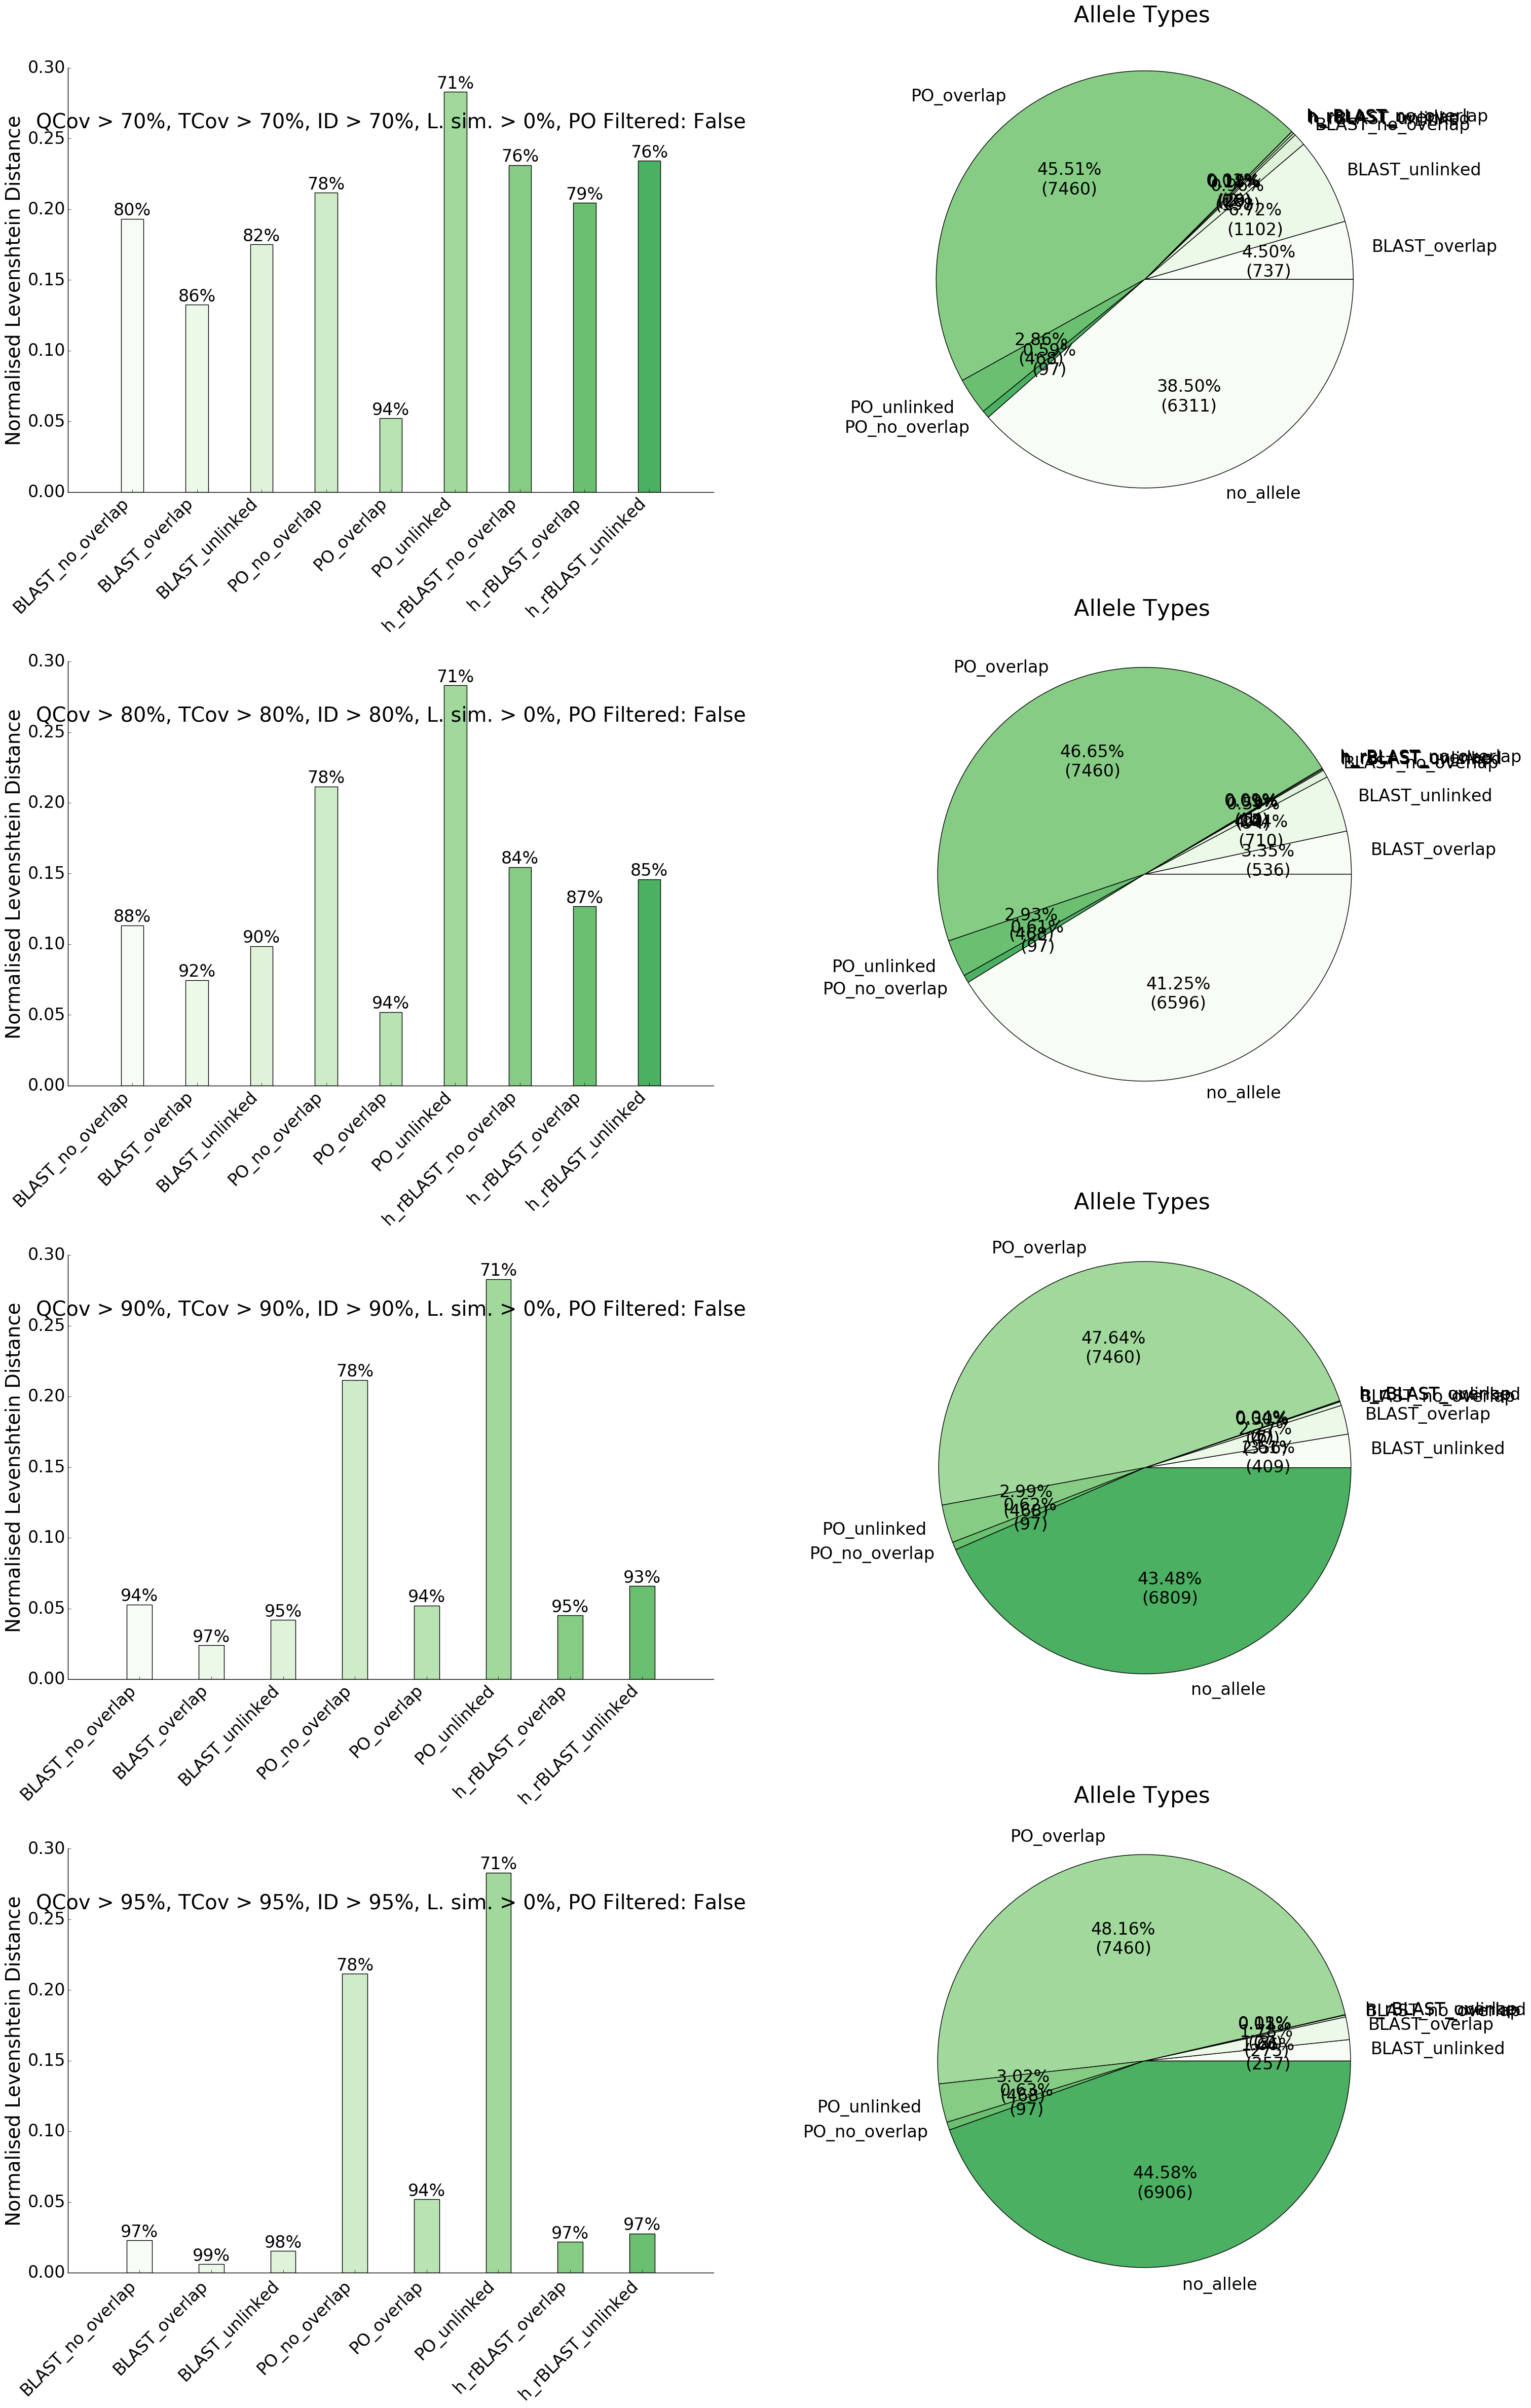

In [19]:
# Used in the pie chart for all text except title
# the ax.pie plotting interface is weird - cannot set other font sizes properly?
mpl.rcParams['font.size'] = 24

TITLE_SIZE = 32
AXIS_LABEL_SIZE = 28
AXIS_TICK_SIZE = 24
INLINE_LABEL_SIZE = 24

# These lists must all be the same length
qCovFilters = [False, 80, 90, 95]
pctIdFilters = [False, 80, 90, 95]
tCovFilters = [False, 80, 90, 95]
levSimFilters = [False, False, False, False]

plotAlleles(alleleDf, qCovFilters, tCovFilters, pctIdFilters, levSimFilters, True)